## 3. Build a CNN having a pre-trained MobileNet as backbone to classify 10 classes. 
 
## 4. Train and test your CNN having a pre-trained MobleNet as backbone to classify images of the CIFAR-10 dataset. Discuss your results by comparing performance between transfer learning + fine tuning and only transfer learning.

### Import necessary modules

In [4]:
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Display loaded data

In [5]:
def display_data(images, titles):
    size = len(images)
    for i in range(size):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap= "gray")
        plt.title(titles[i])
    plt.show()
    plt.close()

## Load images from CIFAR-10 dataset

train_x.shape: (50000, 32, 32, 3), trian_y.shape: (50000, 1), test_x.shape: (10000, 32, 32, 3), test_y.shape: (10000, 1)
train_x.dtype: uint8, trian_y.dtype: uint8, test_x.shape: uint8, test_y.dtype: uint8
train_x.range: 255 - 0, test_x.range: 255 - 0


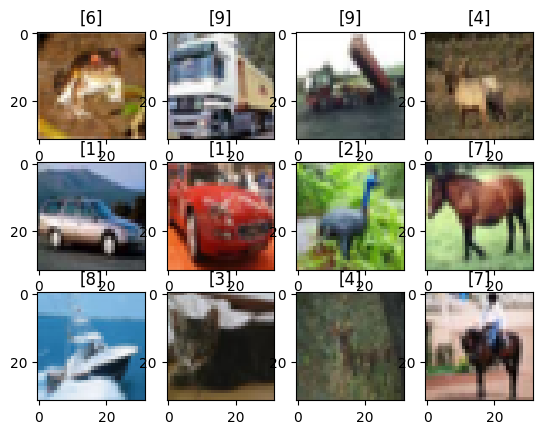

In [6]:
# load data
(train_x, train_y), (test_x, test_y) = load_data()

# print details of loaded data
print(f"train_x.shape: {train_x.shape}, trian_y.shape: {train_y.shape}, test_x.shape: {test_x.shape}, test_y.shape: {test_y.shape}")
print(f"train_x.dtype: {train_x.dtype}, trian_y.dtype: {train_y.dtype}, test_x.shape: {test_x.dtype}, test_y.dtype: {test_y.dtype}")
print(f"train_x.range: {train_x.max()} - {train_x.min()}, test_x.range: {test_x.max()} - {test_x.min()}")

# display some loaded image data
display_data(train_x[:12], train_y[:12])


## Prepare datasets

In [7]:
train_x = np.expand_dims(train_x, axis= -1)
test_x = np.expand_dims(test_x, axis= -1)

print(f"train_x.shape: {train_x.shape}, test_x.shape: {test_x.shape}")
print(f"train_y.dtype: {train_y.dtype}, test_y.dtype: {train_y.dtype}")
print(f"train_x.range: {train_x.max()} - {train_x.min()}, test_x.range: {test_x.max()} - {test_x.min}")

train_y = to_categorical(train_y, num_classes= 10)
test_y = to_categorical(test_y, num_classes= 10)

print(f"train_y.shape: {train_y.shape}, test_y.shape: {test_y.shape}")
print(f"train_y.dtype: {train_y.dtype}, test_y.dtype: {test_y.dtype}")
print(train_y[:10])

train_x.shape: (50000, 32, 32, 3, 1), test_x.shape: (10000, 32, 32, 3, 1)
train_y.dtype: uint8, test_y.dtype: uint8
train_x.range: 255 - 0, test_x.range: 255 - <built-in method min of numpy.ndarray object at 0x0000019D6D35E910>
train_y.shape: (50000, 10), test_y.shape: (10000, 10)
train_y.dtype: float64, test_y.dtype: float64
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Convert to float between range 0 to 1

In [8]:
train_x = train_x.astype("float32") / 255
test_x = test_x.astype("float32") / 255

## Load MobileNet

In [25]:
mobilenet = MobileNet(input_shape=(32, 32, 3), include_top = False)
mobilenet.summary()

C:\Users\tamim\AppData\Local\Temp\ipykernel_9804\4073043969.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_shape=(32, 32, 3), include_top = False)


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 16, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 8, 8, 64)       │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 8, 8, 128)      │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Build a CNN model

In [26]:
inputs_m = mobilenet.inputs
outputs_m = mobilenet.output
x = GlobalAveragePooling2D()(outputs_m)
x = Dense(1024, activation=None)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None)(x)
x = BatchNormalization()(x)
outputs_final = Dense(10, name = "Output_Layer", activation= "softmax")(x)

model = Model(inputs_m, outputs_final, name= "CNN")
model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 16, 16, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 16, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 16, 16, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 16, 16, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 8, 8, 64)       │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 8, 8, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 8, 8, 128)      │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 8, 8, 128)      │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,814,538 (18.37 MB)

 Trainable params: 4,789,578 (18.27 MB)

 Non-trainable params: 24,960 (97.50 KB)

## Freeze layers

In [27]:
for layer in model.layers[:-7]:
    layer.trainable = False
model.summary(show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 32, 32, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 16, 16, 32)    │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_bn                    │ (None, 16, 16, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_relu (ReLU)           │ (None, 16, 16, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1 (DepthwiseConv2D) │ (None, 16, 16, 32)    │        288 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_bn                │ (None, 16, 16, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_relu (ReLU)       │ (None, 16, 16, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1 (Conv2D)          │ (None, 16, 16, 64)    │      2,048 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_bn                │ (None, 16, 16, 64)    │        256 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_relu (ReLU)       │ (None, 16, 16, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pad_2 (ZeroPadding2D)  │ (None, 17, 17, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2 (DepthwiseConv2D) │ (None, 8, 8, 64)      │        576 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_bn                │ (None, 8, 8, 64)      │        256 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_relu (ReLU)       │ (None, 8, 8, 64)      │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2 (Conv2D)          │ (None, 8, 8, 128)     │      8,192 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_bn                │ (None, 8, 8, 128)     │        512 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_relu (ReLU)       │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3 (DepthwiseConv2D) │ (None, 8, 8, 128)     │      1,152 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_bn                │ (None, 8, 8, 128)     │        512 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_relu (ReLU)       │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3 (Conv2D)          │ (None, 8, 8, 128)     │     16,384 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3_bn                │ (None, 8, 8, 128)     │        512 │   N 

 Total params: 4,814,538 (18.37 MB)

 Trainable params: 1,582,602 (6.04 MB)

 Non-trainable params: 3,231,936 (12.33 MB)

## Train model using transfer learning

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, batch_size=128, validation_split=0.1, epochs=5)

Epoch 1/5


c:\Users\tamim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_380']
Received: inputs=Tensor(shape=(None, 32, 32, 3, 1))
  warnings.warn(msg)


352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.2019 - loss: 2.1951 - val_accuracy: 0.2130 - val_loss: 2.1594
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.2027 - loss: 2.1907 - val_accuracy: 0.1918 - val_loss: 2.2031
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.2055 - loss: 2.1791 - val_accuracy: 0.1930 - val_loss: 2.1787
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.2022 - loss: 2.1821 - val_accuracy: 0.2180 - val_loss: 2.1579
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.2076 - loss: 2.1819 - val_accuracy: 0.2086 - val_loss: 2.1656


## Unfreze all layers

In [30]:
for layer in model.layers:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 32, 32, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 16, 16, 32)    │        864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_bn                    │ (None, 16, 16, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1_relu (ReLU)           │ (None, 16, 16, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1 (DepthwiseConv2D) │ (None, 16, 16, 32)    │        288 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_bn                │ (None, 16, 16, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_1_relu (ReLU)       │ (None, 16, 16, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1 (Conv2D)          │ (None, 16, 16, 64)    │      2,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_bn                │ (None, 16, 16, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_1_relu (ReLU)       │ (None, 16, 16, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pad_2 (ZeroPadding2D)  │ (None, 17, 17, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2 (DepthwiseConv2D) │ (None, 8, 8, 64)      │        576 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_bn                │ (None, 8, 8, 64)      │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_2_relu (ReLU)       │ (None, 8, 8, 64)      │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2 (Conv2D)          │ (None, 8, 8, 128)     │      8,192 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_bn                │ (None, 8, 8, 128)     │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_2_relu (ReLU)       │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3 (DepthwiseConv2D) │ (None, 8, 8, 128)     │      1,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_bn                │ (None, 8, 8, 128)     │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_dw_3_relu (ReLU)       │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3 (Conv2D)          │ (None, 8, 8, 128)     │     16,384 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_pw_3_bn                │ (None, 8, 8, 128)     │        512 │   Y 

 Total params: 7,979,744 (30.44 MB)

 Trainable params: 4,789,578 (18.27 MB)

 Non-trainable params: 24,960 (97.50 KB)

 Optimizer params: 3,165,206 (12.07 MB)

## Re-train the model with a lower learning rate

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, batch_size = 128, validation_split = 0.1, epochs = 5)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 138s 354ms/step - accuracy: 0.3323 - loss: 2.3248 - val_accuracy: 0.5706 - val_loss: 1.2388
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 123s 348ms/step - accuracy: 0.6183 - loss: 1.0931 - val_accuracy: 0.6692 - val_loss: 0.9426
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 124s 353ms/step - accuracy: 0.7082 - loss: 0.8347 - val_accuracy: 0.7078 - val_loss: 0.8313
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 122s 346ms/step - accuracy: 0.7637 - loss: 0.6757 - val_accuracy: 0.7280 - val_loss: 0.7925
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 122s 347ms/step - accuracy: 0.8050 - loss: 0.5538 - val_accuracy: 0.7422 - val_loss: 0.7798
